## Lab 4 - part 2: Data Weights and Autocorellation

**TU Delft and WUR**<br>
**Q1 2024**<br>
**Instructor:** Theodoros Chatzivasileiadis <br>
**Instructor:** Hans Hoogenboom <br>
**TA:** Ka Yi Chua <br>
**[Metropolitan Data 1](https://jhoogenboom.github.io/spatial-data-science/_index.html)** <br>



## Exercise 4a: Spatial Autocorrelation and ESDA 

<span style="color:grey">

USE the Liverpool IMD data we have been using in previous sessions. This will require you to:

* Load up the IMD dataset for Liverpool.
* Create a choropleth of the `imd_score` variable.
* Compute the spatial weights matrix for the LSOAs. Think of one criterium to build it that you think would fit this variable (e.g. contiguity, distance-based, etc.), and apply it.
* Create the standardized version of the IMD scores.
* Calculate the spatial lag of the standardized scores.
* Create the Moran Plot.
* Calculate the value of Moran's I as well as its significance level.
* Perform a LISA analysis and generate a map of the results. What are the main patterns?
<span>

For this part I would like you to experiment with Data from Amstedam. However this will require you to find the dataset yourself!











After a considerable amount of time searching for a proper dataset for this exercise, our group has decided to use the given data from lab 4.1. This was done is accord with Theodoros.  

It is near impossible to find a useful shapefile at the website of the municipality of Amsterdam. The few files that do show polygons usually just visualise neighborhood and other political border, without any values attached to them (temperature, population etc.)   

Availability of other open data suitable for this exercise was also scarce. It is either...  
    - in the wrong format (.xml; .csv)   
    - does not contain polygons (rather networks and verteces)   
    - shows categorical data, which can not be analysed through a statistical analysis   
    - costs money to obtain   
    
Promising, but unfortunately not winning, sources were for example: KNMI Data Platform , PDOK/ Nationaal georegister, Overheid.nl, MAQ Observations (WUR) and BBBike extracts.

For these reasons we will solve this exercise with the England dataset. However, there will be a little twist.
    


In [1]:
#import all the important stuff
import seaborn as sns
import pandas as pd
import pysal as ps 
from pysal.lib import weights 
from libpysal.io import open as psopen 
import libpysal 
import esda
from esda.moran import Moran
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation
import geopandas as gpd 
import numpy as np
import matplotlib.pyplot as plt

<Axes: >

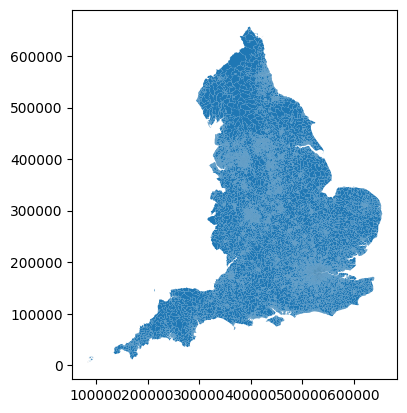

In [2]:
#read in and plot england
#lookup_path = 'data/IMD/OAs/'
imd = gpd.read_file('data/IMD/lab04_imd.shp')
imd.plot()

In [3]:
# get an understanding of the dataframe
imd.head()


,lsoa11cd,lsoa11nm,lsoa11nmw,st_areasha,st_lengths,IMD_Rank,IMD_Decile,LSOA01NM,LADcd,LADnm,...,IndDec,OutScore,OutRank,OutDec,TotPop,DepChi,Pop16_59,Pop60+,WorkPop,geometry
0,E01000001,City of London 001A,City of London 001A,133320.768872,2291.846072,29199,9,City of London 001A,E09000001,City of London,...,5,1.503,1615,1,1296,175,656,465,715.00,"POLYGON ((532105.092 182011.23, 532162.491 181..."
1,E01000002,City of London 001B,City of London 001B,226191.272990,2433.960112,30379,10,City of London 001B,E09000001,City of London,...,7,1.196,2969,1,1156,182,580,394,619.75,"POLYGON ((532746.813 181786.891, 532671.688 18..."
2,E01000003,City of London 001C,City of London 001C,57302.966538,1142.359799,14915,5,City of London 001C,E09000001,City of London,...,6,2.207,162,1,1350,146,759,445,804.00,"POLYGON ((532135.145 182198.119, 532158.25 182..."
3,E01000005,City of London 001E,City of London 001E,190738.760504,2167.868343,8678,3,City of London 001E,E09000001,City of London,...,8,1.769,849,1,1121,229,692,200,683.00,"POLYGON ((533807.946 180767.77, 533649.063 180..."
4,E01000006,Barking and Dagenham 016A,Barking and Dagenham 016A,144195.846857,1935.510354,14486,5,Barking and Dagenham 016A,E09000002,Barking and Dagenham,...,5,0.969,4368,2,2040,522,1297,221,1284.50,"POLYGON ((545122.049 184314.931, 545271.917 18..."


In [4]:
# get an overview of the dataframe
imd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 32844 entries, 0 to 32843
Data columns (total 64 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   lsoa11cd    32844 non-null  object  
 1   lsoa11nm    32844 non-null  object  
 2   lsoa11nmw   32844 non-null  object  
 3   st_areasha  32844 non-null  float64 
 4   st_lengths  32844 non-null  float64 
 5   IMD_Rank    32844 non-null  int64   
 6   IMD_Decile  32844 non-null  int64   
 7   LSOA01NM    32844 non-null  object  
 8   LADcd       32844 non-null  object  
 9   LADnm       32844 non-null  object  
 10  IMDScore    32844 non-null  float64 
 11  IMDRank0    32844 non-null  int64   
 12  IMDDec0     32844 non-null  int64   
 13  IncScore    32844 non-null  float64 
 14  IncRank     32844 non-null  int64   
 15  IncDec      32844 non-null  int64   
 16  EmpScore    32844 non-null  float64 
 17  EmpRank     32844 non-null  int64   
 18  EmpDec      32844 non-null  int64   
 

In [5]:
#save dataframe as .csv file
imd.to_csv('data/England2.csv', sep =',', index = False)

The dataset has a lot of data that is not relevant to this assignment, as we saw when analysing the .csv file. Apparently all areas of England where ranked on various parameters/by different institution.   
In order to simplify and improve run time, we concentrate on the truly relevant columns.

In [6]:
#drop all unnecessary columns
imd = imd[['lsoa11cd', 'lsoa11nm', 'st_areasha', 'st_lengths', 'TotPop', 'DepChi', 'Pop16_59', 'Pop60+', 'WorkPop', 'geometry']]
imd.head()

,lsoa11cd,lsoa11nm,st_areasha,st_lengths,TotPop,DepChi,Pop16_59,Pop60+,WorkPop,geometry
0,E01000001,City of London 001A,133320.768872,2291.846072,1296,175,656,465,715.00,"POLYGON ((532105.092 182011.23, 532162.491 181..."
1,E01000002,City of London 001B,226191.272990,2433.960112,1156,182,580,394,619.75,"POLYGON ((532746.813 181786.891, 532671.688 18..."
2,E01000003,City of London 001C,57302.966538,1142.359799,1350,146,759,445,804.00,"POLYGON ((532135.145 182198.119, 532158.25 182..."
3,E01000005,City of London 001E,190738.760504,2167.868343,1121,229,692,200,683.00,"POLYGON ((533807.946 180767.77, 533649.063 180..."
4,E01000006,Barking and Dagenham 016A,144195.846857,1935.510354,2040,522,1297,221,1284.50,"POLYGON ((545122.049 184314.931, 545271.917 18..."


Here's the twist: We decided to further specify our scope and make this exercise more tangiable. We found that polygons with a smaller area represent  cities and agglomorations. Since we could not find a direct correlation between population and polygon size (by plotting both of columns and comparing iteratively), we want to make a statistical analysis of the population in cities.


<Axes: >

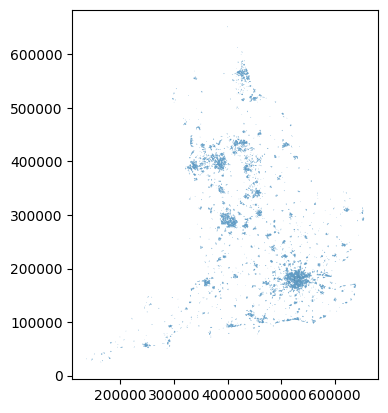

In [7]:
# define all polygons < 750,000 as area of interest
aoi = imd[imd.st_areasha < 750000]
aoi.plot()

From now on only this area of interest will be contemplated when answering these questions.

## Question 1: Building a Contiguity-Based Weight Matrix

Use PySAL to create a contiguity-based weight matrix (W) for a given spatial dataset of polygons. Write a function create_contiguity_weights that:

    Reads in a shapefile of polygons.
    Constructs a Queen contiguity-based spatial weights matrix.
    Returns the weight matrix.

In [8]:
def create_contiguity_weights(area, id):
    # the following to lines of code work (with data/IMD/lab04_imd.shp as input). 
    # since our file in already read in and cleaned up, we commented this out
    '''
    file = input('Please provide the file path')
    area = gpd.read_file(file)
    '''
    #create a queen weigth matrix
    W = weights.Queen.from_dataframe(area, ids = id)
    return W

In [9]:
#execute function with area of interest
wqueen = create_contiguity_weights(aoi, 'lsoa11nm')
wqueen

c:\Users\Dennis\AppData\Local\Programs\Python\Python312\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 1494 disconnected components.
 There are 592 islands with ids: Barnet 016A, Bromley 007F, Croydon 039C, Hillingdon 003B, Redbridge 027D, Manchester 015C, Salford 005C, Salford 014D, Tameside 001D, Tameside 003C, Trafford 027D, Wigan 024E, Wigan 038A, Wigan 004C, Wigan 004D, Wigan 034B, Wigan 012A, Wigan 003G, Wigan 018D, Wigan 018F, Liverpool 058A, Liverpool 022D, St. Helens 002C, Wirral 011A, Wirral 040A, Barnsley 006D, Barnsley 025B, Barnsley 025E, Barnsley 022A, Barnsley 029C, Barnsley 028A, Doncaster 002E, Doncaster 021D, Doncaster 007F, Rotherham 032D, Rotherham 032E, Rotherham 001D, Rotherham 010A, Rotherham 026B, Rotherham 024B, Sheffield 014A, Sheffield 018D, Sheffield 008E, Sheffield 002C, Gateshead 022B, Gateshead 019G, Newcastle upon Tyne 014B, South Tyneside 022D, Sunderland 035A, Birmingham 029E, B

Our data set has 1494 disconnected components and 592 islands.  
This increase of number, in comparison to the lab makes sense taking into account that we dropped a lot of rows from the original dataframe.
The disconnected components stand for groups of nodes (geographic regions) which may internally connect, but do not connect to each other. In our dataset these could be two counties which do not share anyboundary in our area of interest. The islands are single nodes which share very little or no connections or neighbours. In our dataset these could be real, physical islands or just any small, isolated region which is deconnected due to other missing data (e.g. small land parcels).

## Question 2: Calculating Moran’s I

Write a function calculate_morans_i that:

    Takes a spatial weight matrix W and an attribute array y.
    Calculates Moran’s I for the given attribute array.
    Returns the Moran’s I value and its p-value.

In [10]:
def calculate_morans_i(W, y):
    
    # calculate all values that are included in Moran's analysis
    mi = esda.Moran(y, W)

    # specifically return the two values that are required
    mi_I = float(mi.I)
    p_value = float(mi.p_sim)
    return mi_I, p_value


In [11]:
#execute function on the column total population
calculate_morans_i(wqueen, aoi['TotPop'])

('WARNING: ', 'Barnet 016A', ' is an island (no neighbors)')
('WARNING: ', 'Bromley 007F', ' is an island (no neighbors)')
('WARNING: ', 'Croydon 039C', ' is an island (no neighbors)')
('WARNING: ', 'Hillingdon 003B', ' is an island (no neighbors)')
('WARNING: ', 'Redbridge 027D', ' is an island (no neighbors)')
('WARNING: ', 'Manchester 015C', ' is an island (no neighbors)')
('WARNING: ', 'Salford 005C', ' is an island (no neighbors)')
('WARNING: ', 'Salford 014D', ' is an island (no neighbors)')
('WARNING: ', 'Tameside 001D', ' is an island (no neighbors)')
('WARNING: ', 'Tameside 003C', ' is an island (no neighbors)')
('WARNING: ', 'Trafford 027D', ' is an island (no neighbors)')
('WARNING: ', 'Wigan 024E', ' is an island (no neighbors)')
('WARNING: ', 'Wigan 038A', ' is an island (no neighbors)')
('WARNING: ', 'Wigan 004C', ' is an island (no neighbors)')
('WARNING: ', 'Wigan 004D', ' is an island (no neighbors)')
('WARNING: ', 'Wigan 034B', ' is an island (no neighbors)')
('WARNIN

(0.30950008589377725, 0.001)

The p- value is < 5%, meaning that our Moran's I observation of a geo-spatial correlation regarding distance and population is relevant.  
However this might be affected by the fact that we created many more disconnected components and islands, which in turn affect significance and Moran's I as a whole,

## Question 3: Standardizing Spatial Weight Matrices

Create a function standardize_weights that:

    Takes a spatial weight matrix W.
    Standardizes it so that the weights of each row sum to one.
    Returns the standardized weight matrix.

In [12]:
def standardize_weights(W):
    #row-based standartisation
    W.transform = "R"
    return

In [13]:
#execute funtion
standardize_weights(wqueen)
#check if matrix is standartised: 'R' means it worked properly
wqueen.transform

'R'

Every row of the weight matrix sums up to one now

## Question 4: Creating Distance-Based Weights

Write a function create_distance_weights that:

    Takes a set of point coordinates and a threshold distance.
    Constructs a distance-based spatial weight matrix where all points within the threshold distance are assigned a weight.
    Returns the weight matrix.

In [14]:
def create_distance_weight(coordinates, threshold):
    #create a weight matrix where a neighbor is defined if it lies within the threshold distance
    #binary is set to false, to allocate every neighbor the inverse distance weighting D=[0,1], instead of plain true/false statements D={0;1} 
    #alternatively and depending on the progress of the code the methods .from_file(), .from_shapefile, .from_array() etc. can be used
    W = weights.DistanceBand.from_dataframe(coordinates, threshold, binary = 0)
    return W

In [15]:
#execute function with a threshold of 5km (5000m)
create_distance_weight(aoi, 10000)

c:\Users\Dennis\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_data.py:134: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)
c:\Users\Dennis\AppData\Local\Programs\Python\Python312\Lib\site-packages\libpysal\weights\util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 149 disconnected components.
 There are 31 islands with ids: 12724, 13577, 13606, 15820, 18683, 18854, 19079, 20546, 21670, 23387, 24130, 24891, 25397, 25570, 25707, 25774, 25801, 26058, 26348, 26875, 26882, 27080, 28262, 28273, 28381, 28588, 29408, 30426, 30718, 31065, 32420.
  w = W(neighbors, weights, ids, **kwargs)
c:\Users\Dennis\AppData\Local\Programs\Python\Python312\Lib\site-packages\libpysal\weights\distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 149 disconnected components.
 There are 31 islands with ids: 12724, 13577, 13606, 15820, 18683, 18854, 19079, 20546, 21670, 23387, 24130,

There are much less disconnected components and islands compared to Q1. This makes sense, because an even smaller area is viewed.

## Question 5: Visualizing a Moran Plot

Using PySAL, write a function plot_moran that:

    Takes a spatial weights matrix W and an attribute array y.
    Creates and displays a Moran plot for the attribute.
    Saves the Moran plot as an image file.

In [16]:
def plot_moran(W, y):
    # Calculate spatial lag (needed for Moran's plot)
    W_lag = weights.lag_spatial(W, y)
    # Draw an empty coordinate system
    f, ax = plt.subplots(figsize=(9, 9))
    # Put values into coordinate system
    sns.regplot(x = y, y = W_lag)
    # Save Moran plot as image file
    plt.savefig('question_5.png')
    # Show plot
    plt.show()

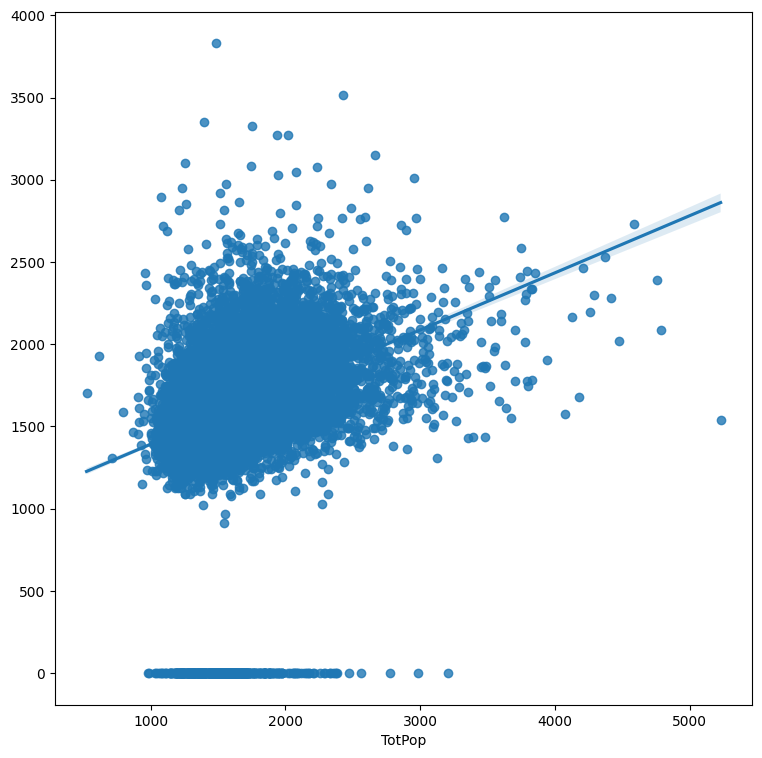

In [17]:
#execute function
plot_moran(wqueen, aoi['TotPop'])

There seems to be a clustering of the geo-spatial correlation of the population. Although there is a trend line it must be observed critically, because there is no clear (linear) correlation of the scattered points.   
Neither, the cluster nor the trendline can be seen in tabular form or in the numeric value of the Moran's I 